In [9]:
import sys
sys.path.append('../')
import config as cf

import tensorflow as tf
import keras.backend.tensorflow_backend
import os
os.environ["CUDA_VISIBLE_DEVICES"]="1"
gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.65)
session = tf.Session(config=tf.ConfigProto(gpu_options=gpu_options))
keras.backend.tensorflow_backend.set_session(session)

from keras.layers import Input, Dense
from keras.models import Model
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, TensorBoard
from keras.models import model_from_json
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, confusion_matrix
import itertools

import random

bs=10

/home/reuben/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/reuben/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
Using TensorFlow backend.
/home/reuben/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)
/home/reuben/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [10]:
model = history = train = validation = train_id = train_label_c = train_label_a = train_mask = valid_id = valid_label_c = valid_label_a = valid_mask = test_id = test_label_c = test_label_a = test_mask = None

In [11]:
def read_data(mode="classification"):
    global train_id, train_label_c, train_label_a, train_mask, valid_id, valid_label_c, valid_label_a, valid_mask, test_id, test_label_c, test_label_a, test_mask, train, validation
    if(mode == "classification"):
        from classification_task.data import main, generate_data
        train_id, train_label_c, valid_id, valid_label_c, test_id, test_label_c=main()
        train=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=True, shuffle=True, batch_size=10, file_list=train_id, label_1=train_label_c)
        validation=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=False, shuffle=True, batch_size=10, file_list=valid_id, label_1=valid_label_c)
        
    elif(mode == "multitask"):
        from multitask.data import main, generate_data
        train_id, train_label_c, train_label_a, train_mask, valid_id, valid_label_c, valid_label_a, valid_mask, test_id, test_label_c, test_label_a, test_mask=main()
        train=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=True, shuffle=True, batch_size=10, file_list=train_id, label_1=train_label_c, label_2=train_label_a, mask=train_mask)
        validation=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=False, shuffle=True, batch_size=10, file_list=valid_id, label_1=valid_label_c, label_2=valid_label_a, mask=valid_mask)
    
    elif(mode == "multitaskauto"):
        from multitask.automated.data import main, generate_data
        train_id, train_label_c, train_label_a, valid_id, valid_label_c, valid_label_a=main()
        train=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=True, shuffle=True, batch_size=10, file_list=train_id, label_1=train_label_c, label_2=train_label_a)
        validation=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/',augmentation=False, shuffle=True, batch_size=10, file_list=valid_id, label_1=valid_label_c, label_2=valid_label_a)
    else:
        raise ValueError('Please specify a known model!')

In [12]:
def build_train_model(mode="classification",runs=200):
    global model, history
    tfdir = cf.DATA_CONFIG['project_folder'] + 'logs/' + mode +'/'
    if not os.path.exists(tfdir):
        os.makedirs(tfdir)
    bs=10
    tensorboard = TensorBoard(log_dir=tfdir, write_graph=True)
    callbacks = [tensorboard]
    #Build the model
    img_height, img_width, img_channel=384,384,3
    input_tensor = Input(shape=(img_height, img_width, img_channel))
    vgg_new_model = keras.applications.vgg16.VGG16(include_top=False, weights='imagenet', input_tensor=input_tensor, input_shape=(img_height, img_width, img_channel), pooling='avg')
    for layer in vgg_new_model.layers[:-5]:
        layer.trainable = False
    result=Dense(100, activation='relu')(vgg_new_model.output)
    result=Dense(100, activation='relu')(result)
    
    if(mode == "classification"):
        result = Dense(1, activation='sigmoid', kernel_initializer='glorot_uniform')(result)
        model = Model(inputs=vgg_new_model.input, outputs=result)
        #Check the model
        model.summary()
        opt=keras.optimizers.SGD(lr=0.001, momentum=0.9)
        
        model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
        history=model.fit_generator(train,steps_per_epoch=(len(train_id)//bs),epochs=runs,validation_steps=(len(valid_id)//bs),validation_data=validation,class_weight={0:1.,1:5.},callbacks=callbacks)
        
    
    elif(mode == "multitask"):
        out_class=Dense(1, activation='sigmoid', name='out_class')(result)
        out_asymm=Dense(1, activation='linear', name='out_asymm')(result)
        model = Model(inputs=vgg_new_model.input, outputs=[out_class, out_asymm])
        #Compile model
        opt=keras.optimizers.SGD(lr=0.001, momentum=0.90)
        model.compile(loss={'out_class': 'binary_crossentropy', 'out_asymm':'mse'}, optimizer=opt, metrics={'out_class': 'accuracy'}, loss_weights={'out_class': 0.5, 'out_asymm': 0.5})
        history=model.fit_generator(train, steps_per_epoch=(len(train_id)//bs), epochs=runs,  class_weight={'out_class':{0:1.,1:5.}}, validation_data=validation, validation_steps=(len(valid_id)//bs),callbacks=callbacks)
        
    elif(mode == "multitaskauto"):
        out_class=Dense(1, activation='sigmoid', name='out_class')(result)
        out_asymm=Dense(1, activation='linear', name='out_asymm')(result)
        model = Model(inputs=vgg_new_model.input, outputs=[out_class, out_asymm])
        #Compile model
        opt=keras.optimizers.SGD(lr=0.001, momentum=0.90)
        model.compile(loss={'out_class': 'binary_crossentropy', 'out_asymm':'mse'}, optimizer=opt, metrics={'out_class': 'accuracy'}, loss_weights={'out_class': 0.5, 'out_asymm': 0.5})
        #Fit model
        history=model.fit_generator(train, steps_per_epoch=(len(train_id)//bs), epochs=runs,  class_weight={'out_class':{0:1.,1:5.}}, validation_data=validation, validation_steps=(len(valid_id)//bs),callbacks=callbacks)
    
    else:
        raise ValueError('Please specify a known model!')
    
    #save model to JSON
    model_json = model.to_json()
    with open(cf.DATA_CONFIG['project_folder'] + "weights/" + mode + ".json", "w") as json_file:
        json_file.write(model_json)
    #serialize weights to HDF5
    model.save_weights(cf.DATA_CONFIG['project_folder'] + "weights/" + mode + ".h5")
    print("Saved" + mode + "model to disk")



In [13]:
def plot(mode="classification"):
    if(mode == "classification"):
        # summarize history for accuracy
        plt.plot(history.history['acc'])
        plt.plot(history.history['val_acc'])
        plt.title('model accuracy')
        plt.ylabel('accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['val_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    if(mode == "multitask" or mode == "multitaskauto"):
        # summarize history for loss
        plt.plot(history.history['loss'])
        plt.plot(history.history['out_class_loss'])
        plt.plot(history.history['val_loss'])
        plt.plot(history.history['val_out_class_loss'])
        plt.title('model loss')
        plt.ylabel('loss')
        plt.xlabel('epoch')
        plt.legend(['train', 'train_class', 'validation', 'validation_class'], loc='upper left')
        plt.show()

        # summarize history for accuracy
        plt.plot(history.history['out_class_acc'])
        plt.plot(history.history['val_out_class_acc'])
        plt.title('model accuracy')
        plt.ylabel('class accuracy')
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        

In [14]:
def second_with_all_layers(mode="classification",runs=200):
    global model,history
    tfdir = cf.DATA_CONFIG['data_folder'] + 'tfboard/' + mode +'/automated/'
    if not os.path.exists(tfdir):
        os.makedirs(tfdir)
    bs=10
    tensorboard = TensorBoard(log_dir=tfdir, write_graph=True)
    callbacks = [tensorboard]
    
    for layer in model.layers:
        layer.trainable = True
    model.summary()
    opt=keras.optimizers.SGD(lr=0.001, momentum=0.90)
    
    if(mode == "classification"):    
        model.compile(loss='binary_crossentropy',optimizer=opt,metrics=['accuracy'])
        history=model.fit_generator(train,steps_per_epoch=(len(train_id)//bs),epochs=runs,validation_steps=(len(valid_id)//bs),validation_data=validation,class_weight={0:1.,1:5.},callbacks=callbacks)
        
    elif(mode == "multitask"):
        model.compile(loss={'out_class': 'binary_crossentropy', 'out_asymm':'mse'}, optimizer=opt, metrics={'out_class': 'accuracy'}, loss_weights={'out_class': 0.5, 'out_asymm': 0.5})
        history=model.fit_generator(train, steps_per_epoch=(len(train_id)//bs), epochs=runs,  class_weight={'out_class':{0:1.,1:5.}}, validation_data=validation, validation_steps=(len(valid_id)//bs),callbacks=callbacks)
        
    elif(mode == "multitaskauto"):
        model.compile(loss={'out_class': 'binary_crossentropy', 'out_asymm':'mse'}, optimizer=opt, metrics={'out_class': 'accuracy'}, loss_weights={'out_class': 0.5, 'out_asymm': 0.5})
        #Fit model
        history=model.fit_generator(train, steps_per_epoch=(len(train_id)//bs), epochs=runs,  class_weight={'out_class':{0:1.,1:5.}}, validation_data=validation, validation_steps=(len(valid_id)//bs),callbacks=callbacks)
    
    else:
        raise ValueError('Please specify a known model!')
    
    #save model to JSON
    model_json = model.to_json()
    with open(cf.DATA_CONFIG['project_folder'] + "weights/" + mode + "_second.json", "w") as json_file:
        json_file.write(model_json)
    #serialize weights to HDF5
    model.save_weights(cf.DATA_CONFIG['project_folder'] + "weights/" + mode + "_second.h5")
    print("Saved" + mode + "model to disk")

In [15]:
def mse(y_true, y_pred):
	mask=[]
	for i in range(0,10):
		if y_true[i]==0	:
			mask.append(0.0)
		else: 
			mask.append(1.0)
	if all(value == 0 for value in mask):
		
		return 0.
	else:
		mask=np.array(mask)
		mask = K.cast(mask, K.floatx())
		score_array = K.square(y_true- y_pred)
		score_array *= mask
		score_array /= K.mean(K.cast(K.not_equal(mask, 0), K.floatx()))
		return K.mean(score_array)
                              

def evaluate(mode="classification"):
    global test_id, test_label_c, model
    if(mode == "classification"):
        from classification_task.data import main, generate_data
        test=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=False, shuffle=False, batch_size=10, file_list=test_id, label_1=test_label_c)
        #Make prediction for class
        y_pred = model.predict_generator(test, steps=25)
        y_pred_c=np.array(y_pred)
        y_true=test_label_c

        #Confusion matrix
        classes={'nevus': 0, 'melanoma': 1}
        thre=0.5
        # obtain class predictions from probabilities
        y_predi=(y_pred_c>=thre)*1
        # obtain (unnormalized) confusion matrix
        cm = confusion_matrix(y_true, y_predi)
        # normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], '.2f'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")
        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/Classification_Confusion_Matrix.png')
        plt.show()

        #ROC curve and score
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(y_true, y_pred)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='aqua', lw=2,
        label='ROC curve  (area = {f:.2f})'.format(f=roc_auc))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('Receiver operating characteristic')
        plt.legend(loc="lower right")
        plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/Classification_ROC_Plot.png')
        plt.show()
    
    elif(mode == "multitask"):
        from multitask.data import main, generate_data
        test=generate_data(directory=cf.DATA_CONFIG['data_folder'] + 'image_data/', augmentation=False, shuffle=False, batch_size=10, file_list=test_id, label_1=test_label_c, label_2=test_label_a, mask=test_mask)
        #Make prediction
        y_pred = model.predict_generator(test, steps=25)
        y_pred_c=(y_pred[0])
        y_true_c=test_label_c
        y_pred_c=np.array(y_pred_c)
        #Confusion matrix
        classes={'nevus': 0, 'melanoma': 1}
        thre=0.5
        # obtain class predictions from probabilities
        y_predi=(y_pred_c>=thre)*1
        # obtain (unnormalized) confusion matrix
        cm = confusion_matrix(y_true_c, y_predi)
        # normalize confusion matrix
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

        plt.figure()
        plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
        plt.title('Confusion matrix')
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)
        thresh = cm.max() / 2.

        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], '.2f'),
                         horizontalalignment="center",
                         color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')
        directory=cf.DATA_CONFIG['project_folder'] + 'reports/multitask/'
        if not os.path.exists(directory):
            os.makedirs(directory)
        plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/multitask/' + 'Multitask_Confusion_Matrix.png')
        plt.show()

        #ROC curve and score
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(y_true_c, y_pred_c)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
        label='ROC curve  (area = {f:.2f})'.format( f=roc_auc))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.title('Receiver operating characteristic')
        plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/multitask/' + 'Multitask_ROC.png')
        plt.show()

        #Calcuate correlation coefficient
        y_pred_a=y_pred[1].reshape((250,))
        y_true_a=np.array(test_label_a)

        #Remove all zeros from missing labels
        for index in range(0,250):
            if y_true_a[index]==0:
                y_pred_a[index]=0

        y_pred_a = y_pred_a[y_pred_a != 0]
        y_true_a = y_true_a[y_true_a != 0]

        r, p = stats.pearsonr(y_true_a, y_pred_a)
        alpha=0.05
        r_z = np.arctanh(r)
        se = 1/np.sqrt(y_true_a.size-3)
        z = stats.norm.ppf(1-alpha/2)
        lo_z, hi_z = r_z-z*se, r_z+z*se
        lo, hi = np.tanh((lo_z, hi_z))
        corr_coef=np.corrcoef(y_pred_a, y_true_a)

        #Plot correlation scatter plot
        y_p_1=[]
        y_t_1=[]
        y_p_2=[]
        y_t_2=[]
        for i in range(len(y_true_a)):
            if test_label_c[i]==1:
                y_p_1.append(y_pred_a[i])
                y_t_1.append(y_true_a[i])
            else:
                y_p_2.append(y_pred_a[i])
                y_t_2.append(y_true_a[i])
        y_p_1=np.array(y_p_1)
        y_t_1=np.array(y_t_1)
        y_p_2=np.array(y_p_2)
        y_t_2=np.array(y_t_2)
        plt.scatter(y_t_1, y_p_1, color='r')	#red points for melanoma
        plt.scatter(y_t_2, y_p_2, color='b')	#blue points for non-melanoma
        plt.xlabel("G_truth")
        plt.ylabel("predicted")
        plt.figtext(0.01, 0.95, 'corr_coef='+str(r), fontsize=10)
        plt.figtext(0.01, 0.92, 'hi='+str(hi), fontsize=10)
        plt.figtext(0.01, 0.89, 'lo='+str(lo), fontsize=10)
        plt.savefig(cf.DATA_CONFIG['project_folder'] + 'reports/multitask/' + 'Correlation_Scatter_Plot.png')
        plt.show()
        
    elif(mode == "multitaskauto"):
        from multitask.automated.data import main, generate_data
        #Read test data
        df=pd.read_csv(cf.DATA_CONFIG['data_folder'] + "ISIC-2017_Test_v2_Part3_GroundTruth.csv") #csv file contains image_id and melanoma label
        test_id=df['image_id']	#image_id list
        test_label_c=df['melanoma']	#binary label
        test_label_a=np.zeros(600) #redundant label to use generator, won't be used later
        #Call data generater
        
        # !!! IMPORTANT!!! Not sure what the mentioned directory below contained
        test=generate_data(directory='/home/ekcontar/crop_test/', augmentation=False, shuffle=False, batch_size=10, file_list=test_id, label_1=test_label_c, label_2=test_label_a)
        #Make prediction
        y_pred = load_model.predict_generator(test, steps=60) #y_pred[0], y_pred[1] are binary, asymmetry label in order
        y_pred_c=(y_pred[0])
        y_pred_c=np.array(y_pred_c)
        y_true_c=test_label_c

        #ROC curve and score
        fpr = dict()
        tpr = dict()
        roc_auc = dict()
        fpr, tpr, _ = roc_curve(y_true_c, y_pred_c)
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, color='darkorange', lw=2,
        label='ROC curve  (area = {f:.2f})'.format( f=roc_auc))
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.legend(loc="lower right")
        plt.title('Receiver operating characteristic')
        plt.show()
        
    else:
        raise ValueError('Please specify a known model!')

In [16]:
def runmodel(model="classification",runs =200):
    read_data(model)
    build_train_model(model,runs)
    plot(model)
    read_data(model)
    second_with_all_layers(model,runs)
    evaluate(model)
    

/home/reuben/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


Epoch 1/20
140/140 [==============================] - 42s 299ms/step - loss: 0.9082 - out_class_loss: 1.2076 - out_asymm_loss: 0.6088 - out_class_acc: 0.4086 - val_loss: 0.4776 - val_out_class_loss: 0.6637 - val_out_asymm_loss: 0.2915 - val_out_class_acc: 0.8086
Epoch 2/20
140/140 [==============================] - 38s 274ms/step - loss: 0.9012 - out_class_loss: 1.1901 - out_asymm_loss: 0.6123 - out_class_acc: 0.3171 - val_loss: 0.4978 - val_out_class_loss: 0.7161 - val_out_asymm_loss: 0.2794 - val_out_class_acc: 0.1914
Epoch 3/20
140/140 [==============================] - 38s 275ms/step - loss: 0.9007 - out_class_loss: 1.1924 - out_asymm_loss: 0.6091 - out_class_acc: 0.2950 - val_loss: 0.5234 - val_out_class_loss: 0.7718 - val_out_asymm_loss: 0.2751 - val_out_class_acc: 0.1914
Epoch 7/20
140/140 [==============================] - 38s 275ms/step - loss: 0.9123 - out_class_loss: 1.2079 - out_asymm_loss: 0.6166 - out_class_acc: 0.2529 - val_loss: 0.4813 - val_out_class_loss: 0.7274 - val

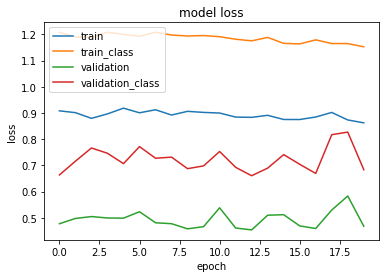

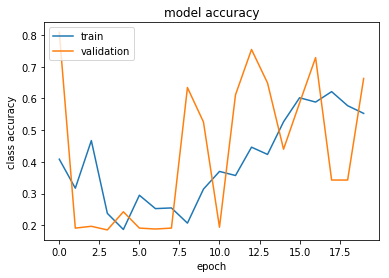

/home/reuben/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:475: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 384, 384, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 384, 384, 64) 1792        input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv2 (Conv2D)           (None, 384, 384, 64) 36928       block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_pool (MaxPooling2D)      (None, 192, 192, 64) 0           block1_conv2[0][0]               
__________________________________________________________________________________________________
block2_con

/home/reuben/anaconda3/lib/python3.6/site-packages/keras/engine/training.py:490: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Epoch 1/20
140/140 [==============================] - 97s 694ms/step - loss: 0.8973 - out_class_loss: 1.2047 - out_asymm_loss: 0.5899 - out_class_acc: 0.6114 - val_loss: 0.4890 - val_out_class_loss: 0.6901 - val_out_asymm_loss: 0.2878 - val_out_class_acc: 0.8086
Epoch 2/20
140/140 [==============================] - 93s 665ms/step - loss: 0.9039 - out_class_loss: 1.2094 - out_asymm_loss: 0.5985 - out_class_acc: 0.5607 - val_loss: 0.4746 - val_out_class_loss: 0.7136 - val_out_asymm_loss: 0.2356 - val_out_class_acc: 0.1914
Epoch 3/20
140/140 [==============================] - 92s 658ms/step - loss: 0.9114 - out_class_loss: 1.2089 - out_asymm_loss: 0.6139 - out_class_acc: 0.1871 - val_loss: 0.4607 - val_out_class_loss: 0.7278 - val_out_asymm_loss: 0.1936 - val_out_class_acc: 0.1857
Epoch 4/20
140/140 [==============================] - 92s 658ms/step - loss: 0.9190 - out_class_loss: 1.2118 - out_asymm_loss: 0.6262 - out_class_acc: 0.1886 - val_loss: 0.5003 - val_out_class_loss: 0.7263 - val

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [17]:
runmodel("multitask",20)